In [11]:
import os
from dotenv import load_dotenv
from langgraph.graph import StateGraph, START, END
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage, ToolMessage, SystemMessage
from typing import TypedDict, Sequence, Annotated
from langchain_google_genai import ChatGoogleGenerativeAI, GoogleGenerativeAIEmbeddings
import getpass
from langchain_core.tools import tool
from langgraph.graph.message import add_messages
from langchain_community.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_chroma import Chroma

In [12]:
load_dotenv()

True

In [13]:
llm = ChatGoogleGenerativeAI(model="gemini-2.5-flash-preview-05-20", temperature = 0.2)
embeddings = GoogleGenerativeAIEmbeddings(model = "models/gemini-embedding-exp-03-07")

In [14]:
pdf_path = "Stock_Market_Performance_2024.pdf"
if not os.path.exists(pdf_path):
  raise FileNotFoundError(f"PDF file not found at {pdf_path}")

pdf_loader = PyPDFLoader(pdf_path)

try:
  pages = pdf_loader.load()
  print(f"PDF of {len(pages)} pages loaded successfully")

except Exception as e:
  print(f"Error loading PDF: {str(e)}")
  raise 

PDF of 9 pages loaded successfully


In [15]:
# Chunking
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)

In [ ]:
pages_split = text_splitter.split_documents(pages)

dir = 'vector-store'
if not os.path.dirname(dir):
  os.makedirs(dir)

collection_name = 'stock_market'

In [ ]:
try:
  vectorstore = Chroma.from_documents(
    documents=pages_split,
    embedding=embeddings,
    persist_directory=dir,
    collection_name=collection_name
  )
  print(f"Chroma vector store created at: {dir}")

except Exception as e:
  print(f"Error in creating chroma vector store: {str(e)}")
  raise

In [ ]:
retriever = vectorstore.as_retriever(
    search_type="similarity",
    search_kwargs={"k": 5} 
)

In [20]:
@tool
def retriever_tool(query: str) -> str:
    """
    This tool searches and returns the information from the Stock Market Performance 2024 document.
    """

    docs = retriever.invoke(query)

    if not docs:
        return "I found no relevant information in the Stock Market Performance 2024 document."
    
    results = []
    for i, doc in enumerate(docs):
        results.append(f"Document {i+1}:\n{doc.page_content}")
    
    return "\n\n".join(results)


tools = [retriever_tool]

In [21]:
llm = llm.bind_tools(tools)

In [22]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]


def should_continue(state: AgentState):
    """Check if the last message contains tool calls."""
    result = state['messages'][-1]
    return hasattr(result, 'tool_calls') and len(result.tool_calls) > 0

In [23]:
system_prompt = """
You are an intelligent AI assistant who answers questions about Stock Market Performance in 2024 based on the PDF document loaded into your knowledge base.
Use the retriever tool available to answer questions about the stock market performance data. You can make multiple calls if needed.
If you need to look up some information before asking a follow up question, you are allowed to do that!
Please always cite the specific parts of the documents you use in your answers.
"""

tools_dict = {our_tool.name: our_tool for our_tool in tools}

def call_llm(state: AgentState) -> AgentState:
    """Function to call the LLM with the current state."""
    messages = list(state['messages'])
    messages = [SystemMessage(content=system_prompt)] + messages
    message = llm.invoke(messages)
    return {'messages': [message]}

In [24]:
def take_action(state: AgentState) -> AgentState:
    """Execute tool calls from the LLM's response."""

    tool_calls = state['messages'][-1].tool_calls
    results = []
    for t in tool_calls:
        print(f"Calling Tool: {t['name']} with query: {t['args'].get('query', 'No query provided')}")
        
        if not t['name'] in tools_dict: # Checks if a valid tool is present
            print(f"\nTool: {t['name']} does not exist.")
            result = "Incorrect Tool Name, Please Retry and Select tool from List of Available tools."
        
        else:
            result = tools_dict[t['name']].invoke(t['args'].get('query', ''))
            print(f"Result length: {len(str(result))}")
            

        # Appends the Tool Message
        results.append(ToolMessage(tool_call_id=t['id'], name=t['name'], content=str(result)))

    print("Tools Execution Complete. Back to the model!")
    return {'messages': results}

In [25]:
graph = StateGraph(AgentState)
graph.add_node("llm", call_llm)
graph.add_node("retriever_agent", take_action)

graph.add_conditional_edges(
    "llm",
    should_continue,
    {True: "retriever_agent", False: END}
)
graph.add_edge("retriever_agent", "llm")
graph.set_entry_point("llm")

rag_agent = graph.compile()

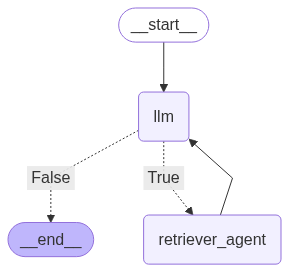

In [26]:
rag_agent

In [ ]:
def running_agent():
    print("\n=== RAG AGENT===")
    
    while True:
        user_input = input("\nWhat is your question: ")
        if user_input.lower() in ['exit', 'quit']:
            break
            
        messages = [HumanMessage(content=user_input)] # converts back to a HumanMessage type

        result = rag_agent.invoke({"messages": messages})
        
        print("\n=== ANSWER ===")
        print(result['messages'][-1].content)

In [ ]:
running_agent()